In [107]:
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [108]:
class HiddenLayer:
    def __init__(self, initialWeights, initialBias, activationFunction):
        self.w = initialWeights # weights
        self.b = initialBias    # bias
        self.i = None           # input
        self.z = None           # output
        self.d = None           # delta
        self.a = None
        self.actFunc = activationFunction
    
    def forward(self, input):
        self.i = input
        self.z = np.dot(input, self.w.T) + self.b
        self.a = self.actFunc.f(self.z)
    
    def backward(self, nextLayerDelta, nextLayerWeights):
        self.d = np.dot(nextLayerDelta, nextLayerWeights) * self.actFunc.f_prime(self.z)
    
    def update(self, learningRate, lam):
        self.w -= learningRate * (np.dot(self.d.T, self.i) + lam * self.w)
        self.b -= learningRate * self.d.sum(axis=0)

class OutputLayer(HiddenLayer):
    def __init__(self, initialWeights, initialBias, activationFunction):
        super().__init__(initialWeights, initialBias, activationFunction)
    
    def backward(self, target):
        self.d = (self.a - target) * self.actFunc.f_prime(self.z)

In [109]:
class ActivationSigmoid:
    def f(self, x):
        return 1 / (1 + np.exp(-x))
    
    def f_prime(self, x):
        return self.f(x) * (1 - self.f(x))
    
class ActivationReLU:
    def f(self, x):
        return np.maximum(0, x)
    
    def f_prime(self, x):
        return np.where(x > 0, 1, 0)

class ActivationTanh:
    def f(self, x):
        return np.tanh(x)
    
    def f_prime(self, x):
        return 1 - np.tanh(x) ** 2

In [110]:
class NeuralNetwork:
    def __init__(self, layers, learningRate):
        self.layers = layers
        self.learningRate = learningRate
        self.cost_over_time_training = None
        self.accuracy_over_time_training = None
        self.cost_over_time_validation = None
        self.accuracy_over_time_validation = None
    
    def forward(self, input):
        for layer in self.layers:
            layer.forward(input)
            input = layer.a
    
    def backward(self, target):
        for i in reversed(range(len(self.layers))):
            if i == len(self.layers) - 1:
                self.layers[i].backward(target)
            else:
                self.layers[i].backward(self.layers[i+1].d, self.layers[i+1].w)
    
    def update(self, learningRate, lam):
        for layer in self.layers:
            layer.update(learningRate, lam)
    
    def predict(self, input):
        self.forward(input)
        return self.layers[-1].a
    
    def cost(self, target, lam):
        mse = (0.5 / target.shape[0]) * np.sum((target - self.layers[-1].a)**2)
        l2_reg = 0.5 * lam * sum(np.sum(layer.w**2) for layer in self.layers[:-1])  # Exclude output layer
        return mse + l2_reg
    
    def accuracy(self, X, y):
        predictions = np.argmax(self.predict(X), axis=1)
        y_vals = np.argmax(y, axis=1)
        return np.mean(predictions == y_vals)
    
    def train(self, X, y, epochs, lam, X_val=None, y_val=None):
        self.cost_over_time_training = []
        self.accuracy_over_time_training = []
        if X_val is not None and y_val is not None:
            self.cost_over_time_validation = []
            self.accuracy_over_time_validation = []
        for _ in range(epochs):
            self.forward(X)
            self.backward(y)
            self.update(self.learningRate, lam)
            self.cost_over_time_training.append(self.cost(y, lam))
            self.accuracy_over_time_training.append(self.accuracy(X, y))
            if X_val is not None and y_val is not None:
                self.forward(X_val)
                self.cost_over_time_validation.append(self.cost(y_val, lam))
                self.accuracy_over_time_validation.append(self.accuracy(X_val, y_val))
    
    def graph_cost_over_time(self):
        # plots the cost over time for training and validation together
        plt.plot(self.cost_over_time_training, label="Training")
        if self.cost_over_time_validation is not None:
            plt.plot(self.cost_over_time_validation, label="Validation")
        plt.title("Cost over time")
        plt.xlabel("Epochs")
        plt.ylabel("Cost")
        plt.legend()
        # show precise value for first and last epoch
        plt.annotate(str(round(self.cost_over_time_training[0], 4)), xy=(0, self.cost_over_time_training[0]))
        plt.annotate(str(round(self.cost_over_time_training[-1], 4)), xy=(len(self.cost_over_time_training)-1, self.cost_over_time_training[-1]))
        if self.cost_over_time_validation is not None:
            plt.annotate(str(round(self.cost_over_time_validation[0], 4)), xy=(0, self.cost_over_time_validation[0]))
            plt.annotate(str(round(self.cost_over_time_validation[-1], 4)), xy=(len(self.cost_over_time_validation)-1, self.cost_over_time_validation[-1]))
        plt.show()
        
    def graph_accuracy_over_time(self):
        plt.plot(self.accuracy_over_time_training, label="Training")
        if self.accuracy_over_time_validation is not None:
            plt.plot(self.accuracy_over_time_validation, label="Validation")
        plt.title("Accuracy over time")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        # show precise value for first and last epoch
        plt.annotate(str(round(self.accuracy_over_time_training[0], 4)), xy=(0, self.accuracy_over_time_training[0]))
        plt.annotate(str(round(self.accuracy_over_time_training[-1], 4)), xy=(len(self.accuracy_over_time_training)-1, self.accuracy_over_time_training[-1]))
        if self.accuracy_over_time_validation is not None:
            plt.annotate(str(round(self.accuracy_over_time_validation[0], 4)), xy=(0, self.accuracy_over_time_validation[0]))
            plt.annotate(str(round(self.accuracy_over_time_validation[-1], 4)), xy=(len(self.accuracy_over_time_validation)-1, self.accuracy_over_time_validation[-1]))
        plt.show()
    
    def graph_cost_and_accuracy_over_time(self):
        # graph cost and accuracy next to each other
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.cost_over_time_training, label="Training")
        if self.cost_over_time_validation is not None:
            ax1.plot(self.cost_over_time_validation, label="Validation")
        ax1.set_title("Cost over time")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Cost")
        ax1.legend()
        # show precise value for first and last epoch
        ax1.annotate(str(round(self.cost_over_time_training[0], 4)), xy=(0, self.cost_over_time_training[0]))
        ax1.annotate(str(round(self.cost_over_time_training[-1], 4)), xy=(len(self.cost_over_time_training)-1, self.cost_over_time_training[-1]))
        if self.cost_over_time_validation is not None:
            ax1.annotate(str(round(self.cost_over_time_validation[0], 4)), xy=(0, self.cost_over_time_validation[0]))
            ax1.annotate(str(round(self.cost_over_time_validation[-1], 4)), xy=(len(self.cost_over_time_validation)-1, self.cost_over_time_validation[-1]))
        
        ax2.plot(self.accuracy_over_time_training, label="Training")
        if self.accuracy_over_time_validation is not None:
            ax2.plot(self.accuracy_over_time_validation, label="Validation")
        ax2.set_title("Accuracy over time")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        # show precise value for first and last epoch
        ax2.annotate(str(round(self.accuracy_over_time_training[0], 4)), xy=(0, self.accuracy_over_time_training[0]))
        ax2.annotate(str(round(self.accuracy_over_time_training[-1], 4)), xy=(len(self.accuracy_over_time_training)-1, self.accuracy_over_time_training[-1]))
        if self.accuracy_over_time_validation is not None:
            ax2.annotate(str(round(self.accuracy_over_time_validation[0], 4)), xy=(0, self.accuracy_over_time_validation[0]))
            ax2.annotate(str(round(self.accuracy_over_time_validation[-1], 4)), xy=(len(self.accuracy_over_time_validation)-1, self.accuracy_over_time_validation[-1]))
        
        plt.show()
    
    def print(self):
        for i, layer in enumerate(self.layers):
            print("Layer", i)
            print("Weights:\n", layer.w)
            print("Bias:\n", layer.b)
            print()

In [111]:
def BuildNetwork(structure, activation_function, initialization=np.zeros, learning_rate=0.1):
    layers = []
    for i in range(len(structure)-2):
        layers.append(HiddenLayer(
            initialization(structure[i+1], structure[i]),
            initialization(1, structure[i+1]),
            activation_function
        ))
    layers.append(OutputLayer(
        initialization(structure[-1], structure[-2]),
        initialization(1, structure[-1]),
        activation_function
    ))

    return NeuralNetwork(layers, learning_rate)

def ZerosInitialization(m, n):
    return np.zeros((m, n))

def UniformInitialization(m, n):
    limit = np.sqrt(6 / (m + n))
    return np.random.uniform(-limit, limit, (m, n))

def NormalInitialization(m, n):
    std = np.sqrt(2 / (m + n))
    return np.random.normal(0, std, (m, n))    

In [115]:
loaded = arff.loadarff('../connect-4.arff')

data = np.asarray(loaded[0].tolist(), dtype=np.float32)
X = data[:, :-1]
y = data[:, -1]

# extract the classes
X_zeros = X[y == 0]
y_zeros = y[y == 0]
X_ones = X[y == 1]
y_ones = y[y == 1]
X_twos = X[y == 2]
y_twos = y[y == 2]

max_from_each_class = min(X_zeros.shape[0], X_ones.shape[0], X_twos.shape[0])
print("max_from_each_class:", max_from_each_class)

# shuffle
np.random.seed(10)
X_zeros, y_zeros = shuffle(X_zeros, y_zeros)
X_ones, y_ones = shuffle(X_ones, y_ones)
X_twos, y_twos = shuffle(X_twos, y_twos)
reduced_X = np.concatenate((X_zeros[:max_from_each_class], X_ones[:max_from_each_class], X_twos[:max_from_each_class]))
reduced_y = np.concatenate((y_zeros[:max_from_each_class], y_ones[:max_from_each_class], y_twos[:max_from_each_class]))

# split into train, test, validation
X_train, X_testval, y_train, y_testval = train_test_split(reduced_X, reduced_y, test_size=0.2, random_state=10)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=0.5, random_state=10)

# one hot encoding
y_train = np.eye(3)[y_train.astype(int)]
y_test = np.eye(3)[y_test.astype(int)]
y_val = np.eye(3)[y_val.astype(int)]
# convert 2s to -1s
X_train[X_train == 2] = -1
X_test[X_test == 2] = -1
X_val[X_val == 2] = -1

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

max_from_each_class: 6449
X_train: (15477, 42)
y_train: (15477, 3)
X_test: (1935, 42)
y_test: (1935, 3)
X_val: (1935, 42)
y_val: (1935, 3)


In [113]:
def TrainNetworks(networks, epochs, lams=[0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):
    network_best_accuracy = [0 for _ in networks]
    network_best_lambda = [0 for _ in networks]
    for i, network in enumerate(networks):
        print("Training network", i+1)
        for lam in lams:
            print("Lambda:", lam, end="... ")
            network.train(X_train, y_train, epochs, lam, X_val, y_val)
            acc = network.accuracy(X_val, y_val)
            print("Accuracy:", acc)
            if acc > network_best_accuracy[i]:
                network_best_accuracy[i] = acc
                network_best_lambda[i] = lam
        print("Best accuracy:", network_best_accuracy[i], "with lambda", network_best_lambda[i], "\n")
        network.graph_cost_and_accuracy_over_time()
    # get index of best accuracy
    best_network_index = network_best_accuracy.index(max(network_best_accuracy))
    print("Best network is network", best_network_index+1, "with accuracy", network_best_accuracy[best_network_index], "and lambda", network_best_lambda[best_network_index])
    return networks[best_network_index]

Training network 1
Lambda: 0... Accuracy: 0.21897457158651187
Lambda: 0.1... Accuracy: 0.3859176340519624
Lambda: 1... Accuracy: 0.6312880044223328
Best accuracy: 0.6312880044223328 with lambda 1 



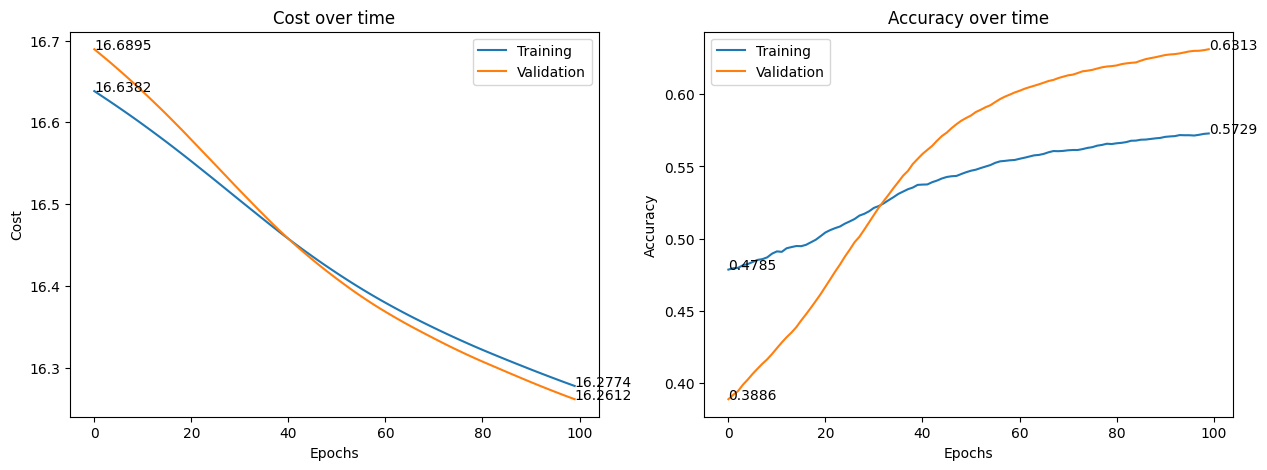

Training network 2
Lambda: 0... Accuracy: 0.4992744610281924
Lambda: 0.1... Accuracy: 0.5441196793808734
Lambda: 1... Accuracy: 0.5748687119955777
Best accuracy: 0.5748687119955777 with lambda 1 



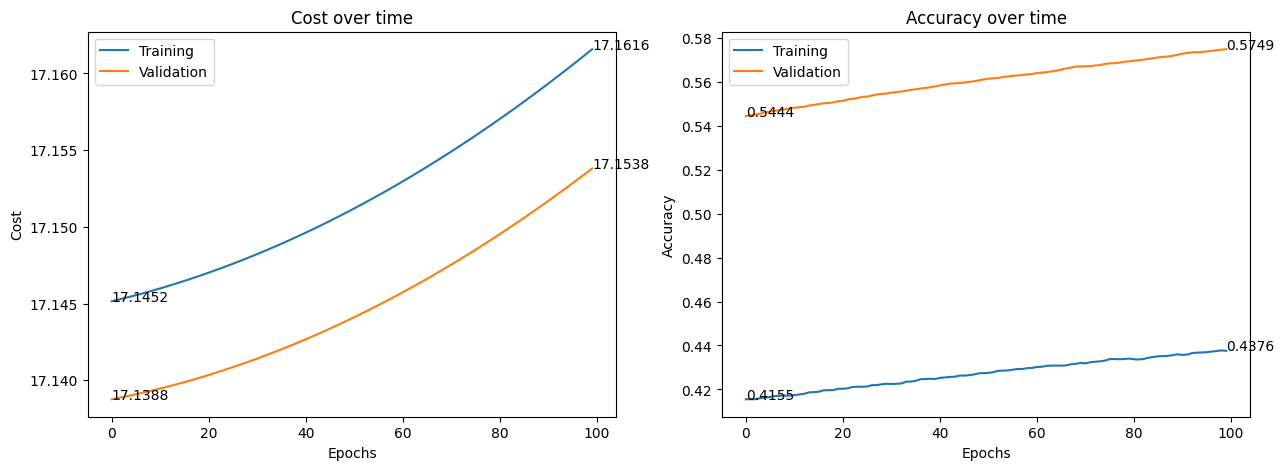

Training network 3
Lambda: 0... Accuracy: 0.5867882808181316
Lambda: 0.1... Accuracy: 0.6688778330569375
Lambda: 1... Accuracy: 0.6870854063018242
Best accuracy: 0.6870854063018242 with lambda 1 



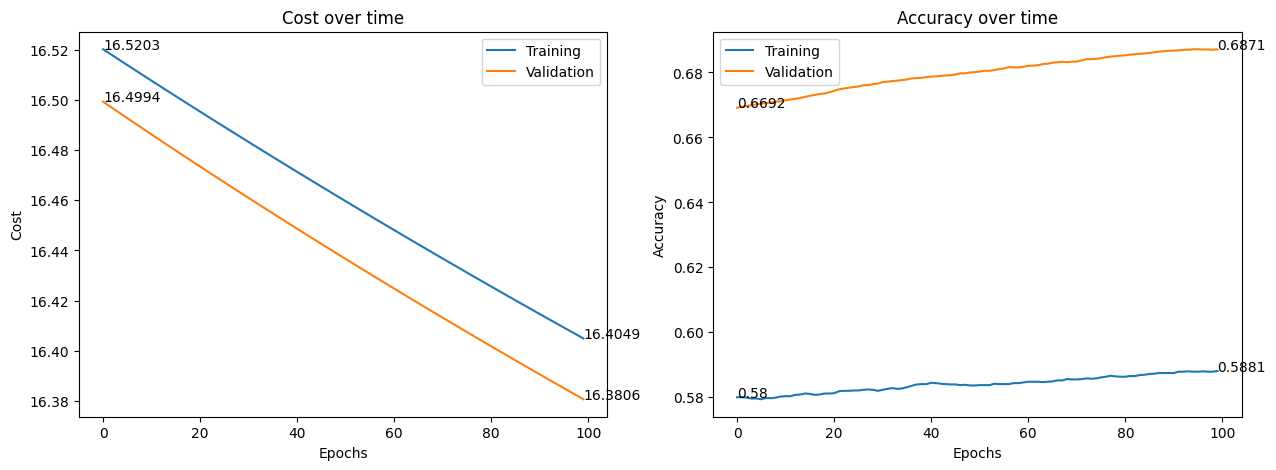

Training network 4
Lambda: 0... Accuracy: 0.48269071310116085
Lambda: 0.1... Accuracy: 0.5014510779436152
Lambda: 1... Accuracy: 0.5197968490878938
Best accuracy: 0.5197968490878938 with lambda 1 



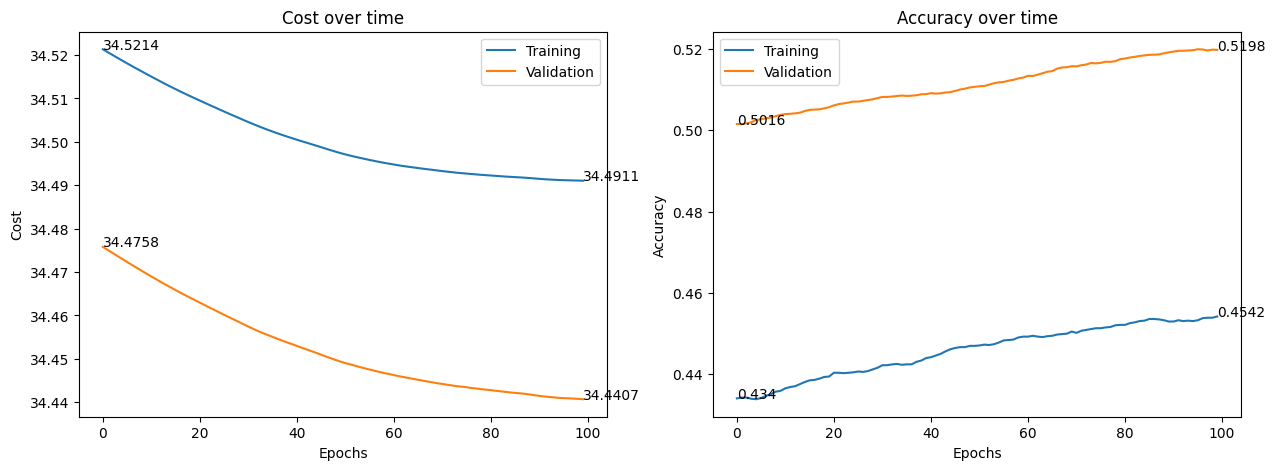

Training network 5
Lambda: 0... Accuracy: 0.710820895522388
Lambda: 0.1... Accuracy: 0.37081951354339415
Lambda: 1... Accuracy: 0.31975538971807627
Best accuracy: 0.710820895522388 with lambda 0 



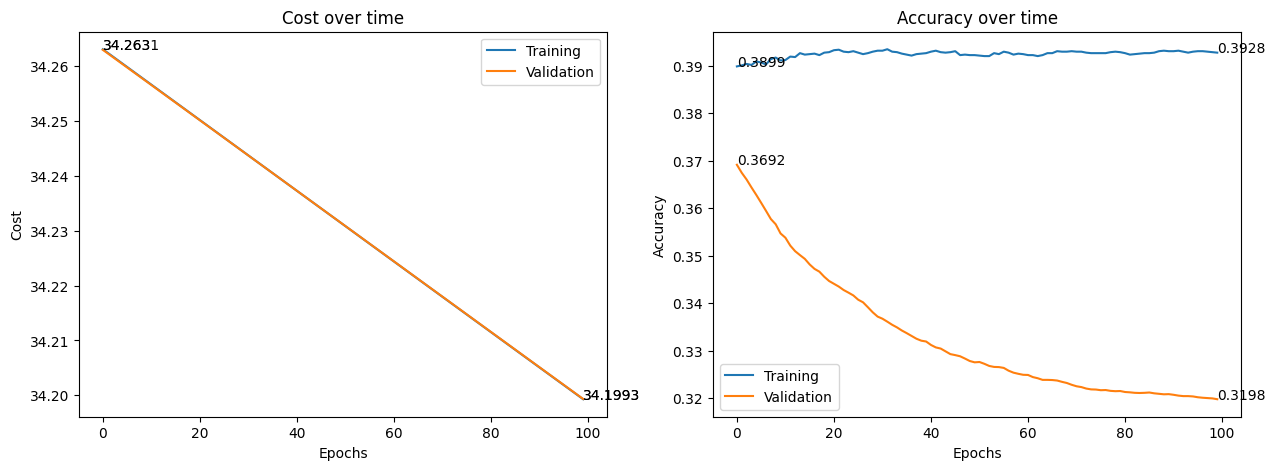

Training network 6
Lambda: 0... Accuracy: 0.6470080154781648
Lambda: 0.1... Accuracy: 0.6862216694306247
Lambda: 1... Accuracy: 0.6959646213377557
Best accuracy: 0.6959646213377557 with lambda 1 



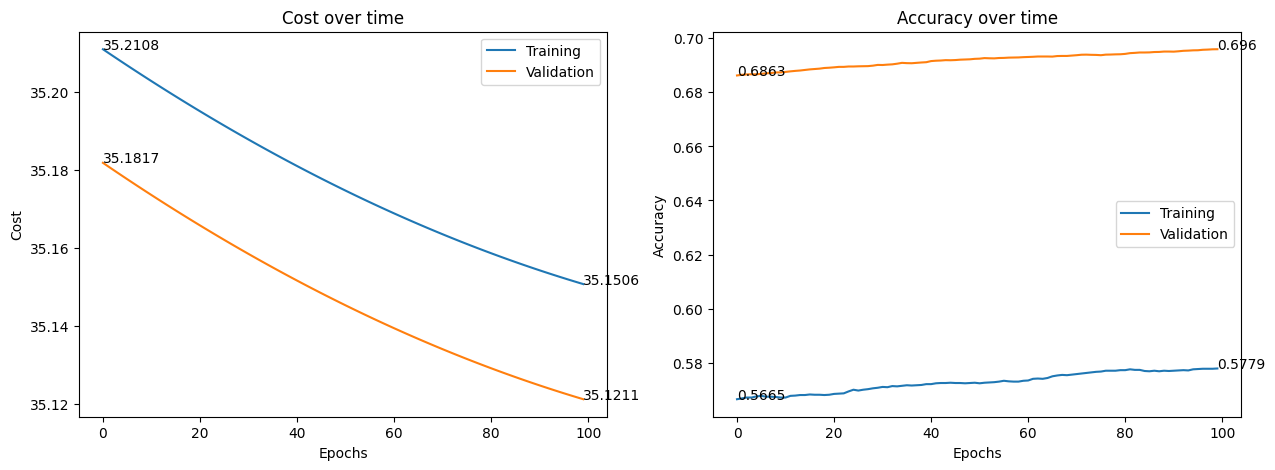

Training network 7
Lambda: 0... Accuracy: 0.7125829187396352
Lambda: 0.1... Accuracy: 0.7125829187396352
Lambda: 1... Accuracy: 0.7122374239911553
Best accuracy: 0.7125829187396352 with lambda 0 



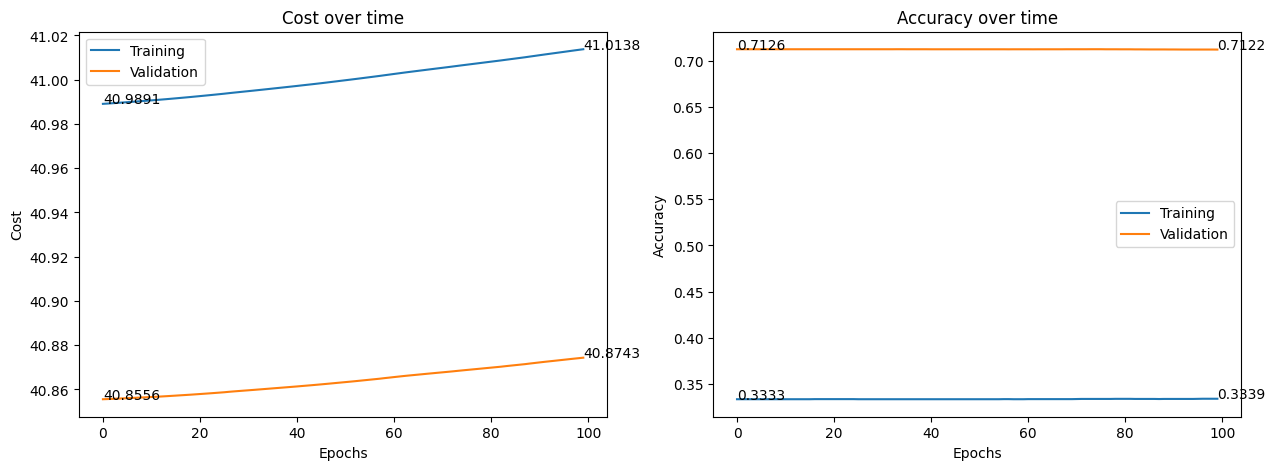

Training network 8
Lambda: 0... Accuracy: 0.23168877833056936
Lambda: 0.1... Accuracy: 0.24896351575456052
Lambda: 1... Accuracy: 0.3675718629076838
Best accuracy: 0.3675718629076838 with lambda 1 



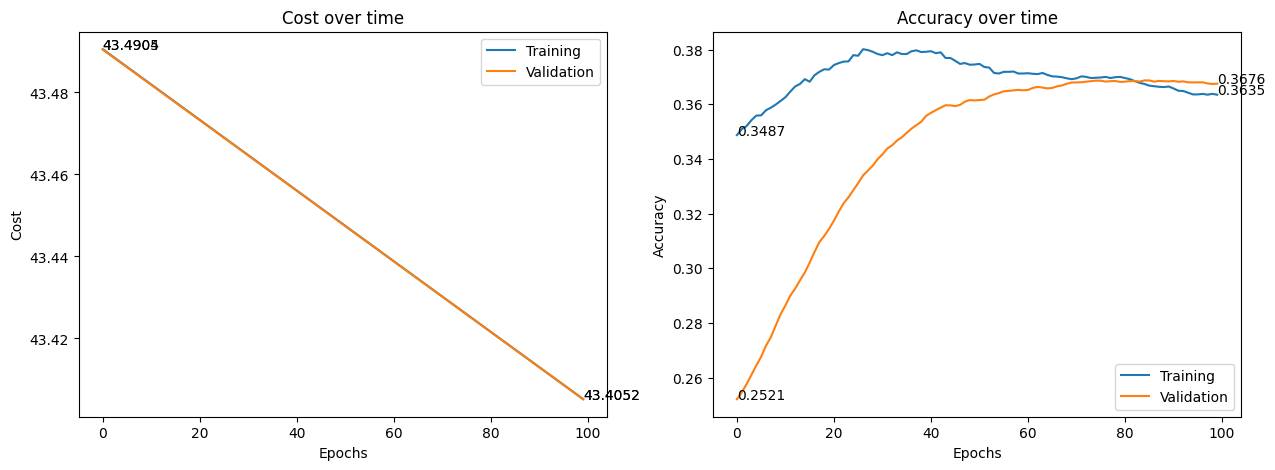

Training network 9
Lambda: 0... 

KeyboardInterrupt: 

In [114]:
layers = [[42, 30, 3], [42, 30, 15, 15, 3], [42, 30, 15, 15, 15, 3], [42, 30, 15, 15, 15, 15, 3]]
activations = [ActivationReLU(), ActivationSigmoid(), ActivationTanh()]
initializations = [NormalInitialization]

networks = []
for layer in layers:
    for activation in activations:
        for initialization in initializations:
            networks.append(BuildNetwork(layer, activation, initialization, 0.00001))

network = TrainNetworks(networks, 100, lams=[0, 0.1, 1])
